# HMC Neural Network

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import seaborn as sns
import sklearn
import theano
import theano.tensor as T

from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons, make_circles
from warnings import filterwarnings

print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.8


In [2]:
%config InlineBackend.figure_format = 'retina'
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"
floatX = theano.config.floatX
filterwarnings('ignore')
sns.set_style('white')

In [100]:
X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)
X = X.astype(floatX)
Y = Y.astype(floatX)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)

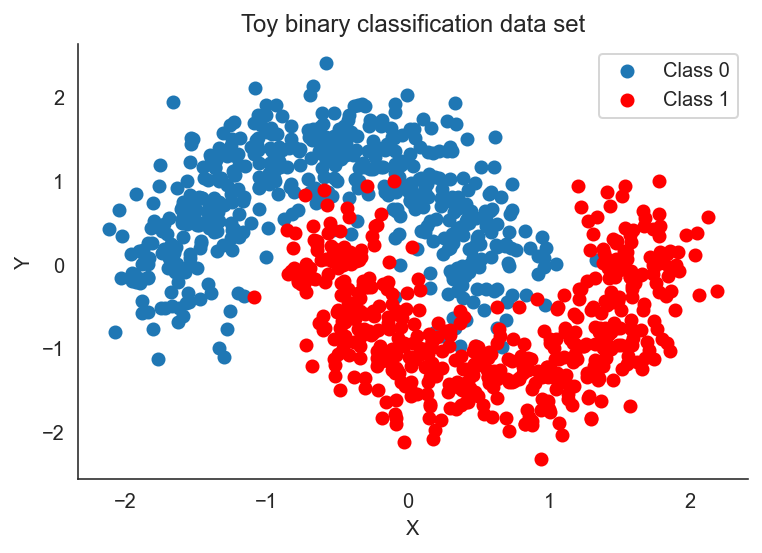

In [101]:
fig, ax = plt.subplots()
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
sns.despine(); ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Toy binary classification data set');

In [5]:
def construct_nn(ann_input, ann_output):
    n_hidden = 5

    # Initialize random weights between each layer
    init_1 = np.random.randn(X.shape[1], n_hidden).astype(floatX)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
    init_out = np.random.randn(n_hidden).astype(floatX)

    with pm.Model() as neural_network:
        # Trick: Turn inputs and outputs into shared variables using the data container pm.Data
        # It's still the same thing, but we can later change the values of the shared variable
        # (to switch in the test-data later) and pymc3 will just use the new data.
        # Kind-of like a pointer we can redirect.
        # For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
        ann_input = pm.Data('ann_input', X_train)
        ann_output = pm.Data('ann_output', Y_train)

        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sigma=1,
                                 shape=(X.shape[1], n_hidden),
                                 testval=init_1)

        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_1_2', 0, sigma=1,
                                shape=(n_hidden, n_hidden),
                                testval=init_2)

        # Weights from hidden layer to output
        weights_2_out = pm.Normal('w_2_out', 0, sigma=1,
                                  shape=(n_hidden,),
                                  testval=init_out)

        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input,
                                         weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1,
                                         weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2,
                                              weights_2_out))

        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli('out',
                           act_out,
                           observed=ann_output,
                           total_size=Y_train.shape[0] # IMPORTANT for minibatches
                          )
    return neural_network

neural_network = construct_nn(X_train, Y_train)

In [6]:
from pymc3.theanof import set_tt_rng, MRG_RandomStreams
set_tt_rng(MRG_RandomStreams(42))

In [12]:
with neural_network:
    steps = pm.NUTS()
    #use the specify sampler to sample from the posterior of the model
    trace = pm.sample(5000, step=steps, tune=1000, chains=1)

Sequential sampling (1 chains in 1 job)
NUTS: [w_2_out, w_1_2, w_in_1]
Sampling chain 0, 827 divergences: 100%|██████████| 6000/6000 [04:14<00:00, 23.55it/s]
There were 827 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6481552724960479, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [78]:
pm.set_data(new_data={'ann_input': X_test, 'ann_output': Y_test}, model=neural_network)
ppc = pm.sample_posterior_predictive(trace, samples=500, progressbar=False, model=neural_network)

In [79]:
pred = ppc["out"].mean(axis=0) > 0.5

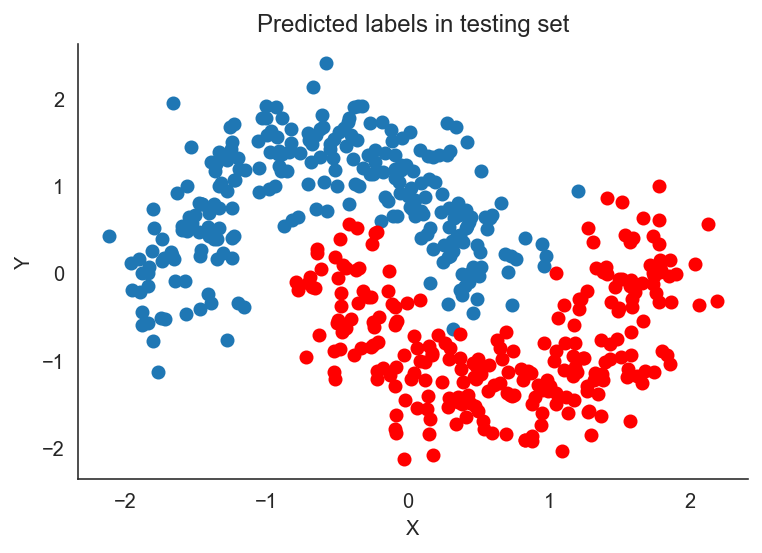

In [81]:
fig, ax = plt.subplots()
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
sns.despine()
ax.set(title='Predicted labels in testing set', xlabel='X', ylabel='Y');

In [49]:
print('Accuracy = {}%'.format((Y_test == pred).mean() * 100))

Accuracy = 97.6%


In [56]:
grid = pm.floatX(np.mgrid[-3:3:100j,-3:3:100j])
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

In [58]:
pm.set_data(new_data={'ann_input': grid_2d, 'ann_output': dummy_out}, model=neural_network)
ppc = pm.sample_posterior_predictive(trace, samples=500, progressbar=False, model=neural_network)

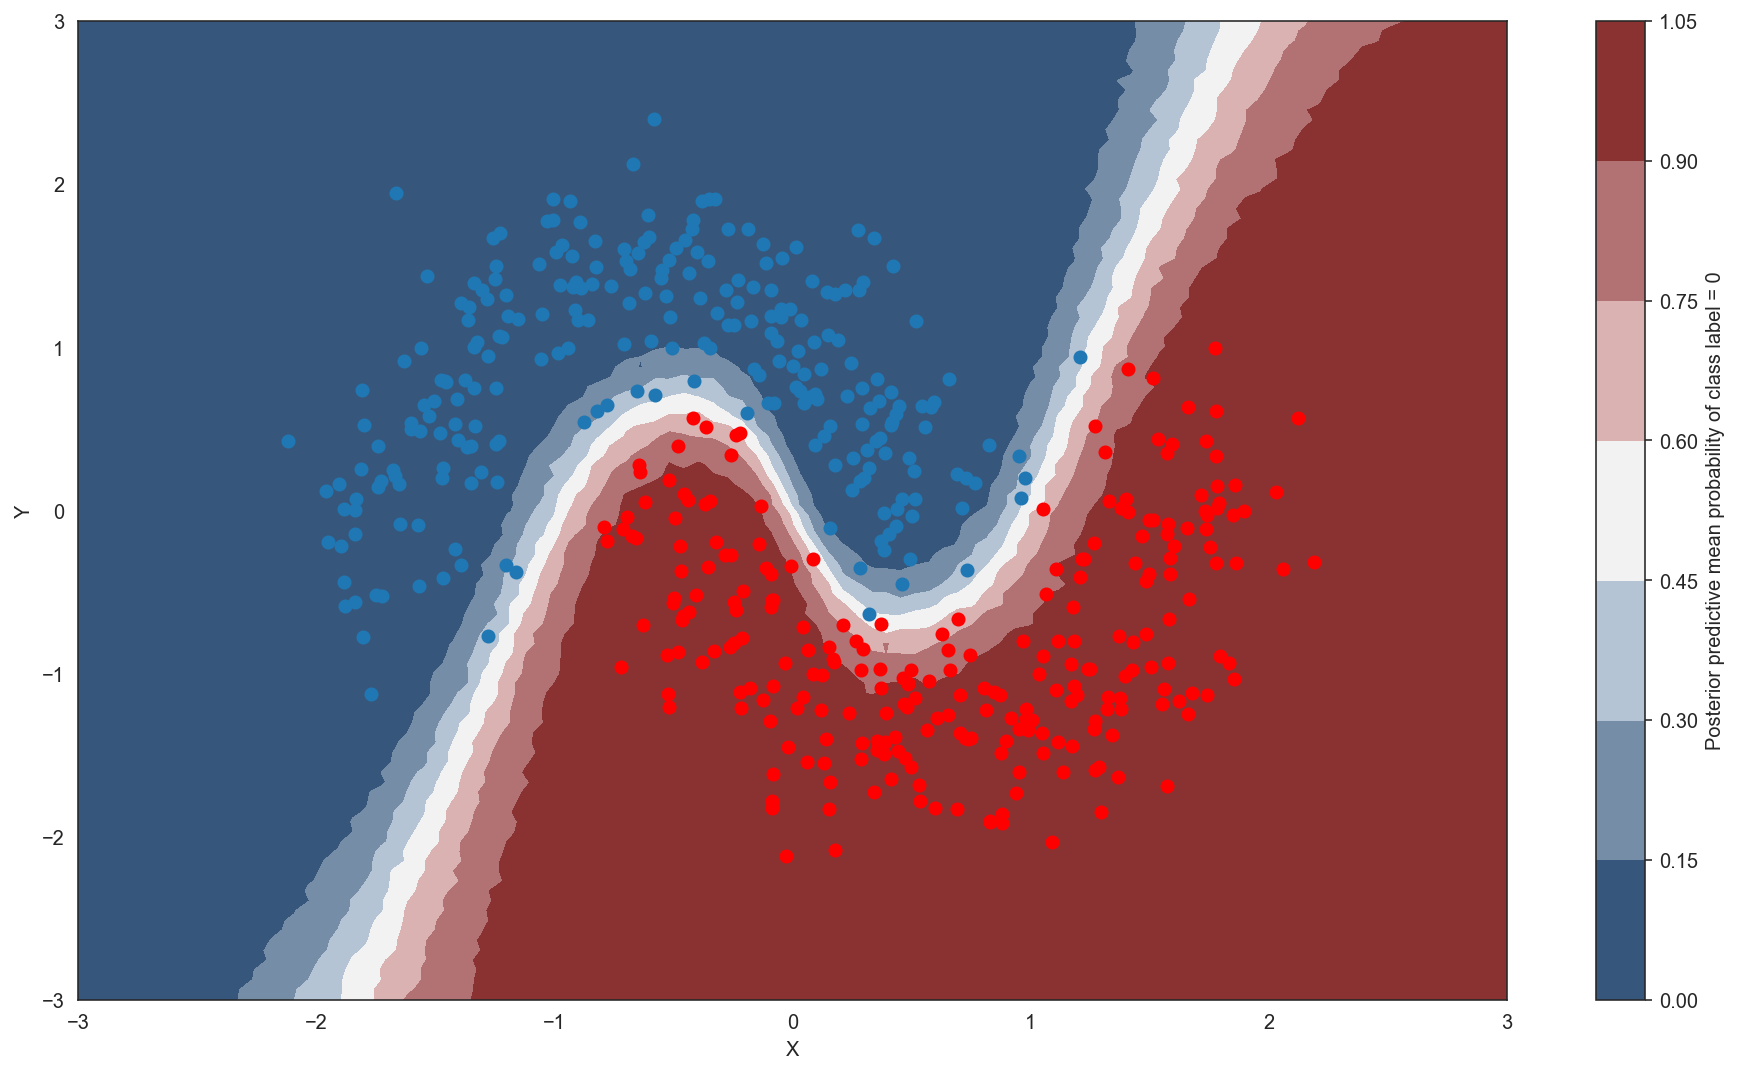

In [52]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], ppc["out"].mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

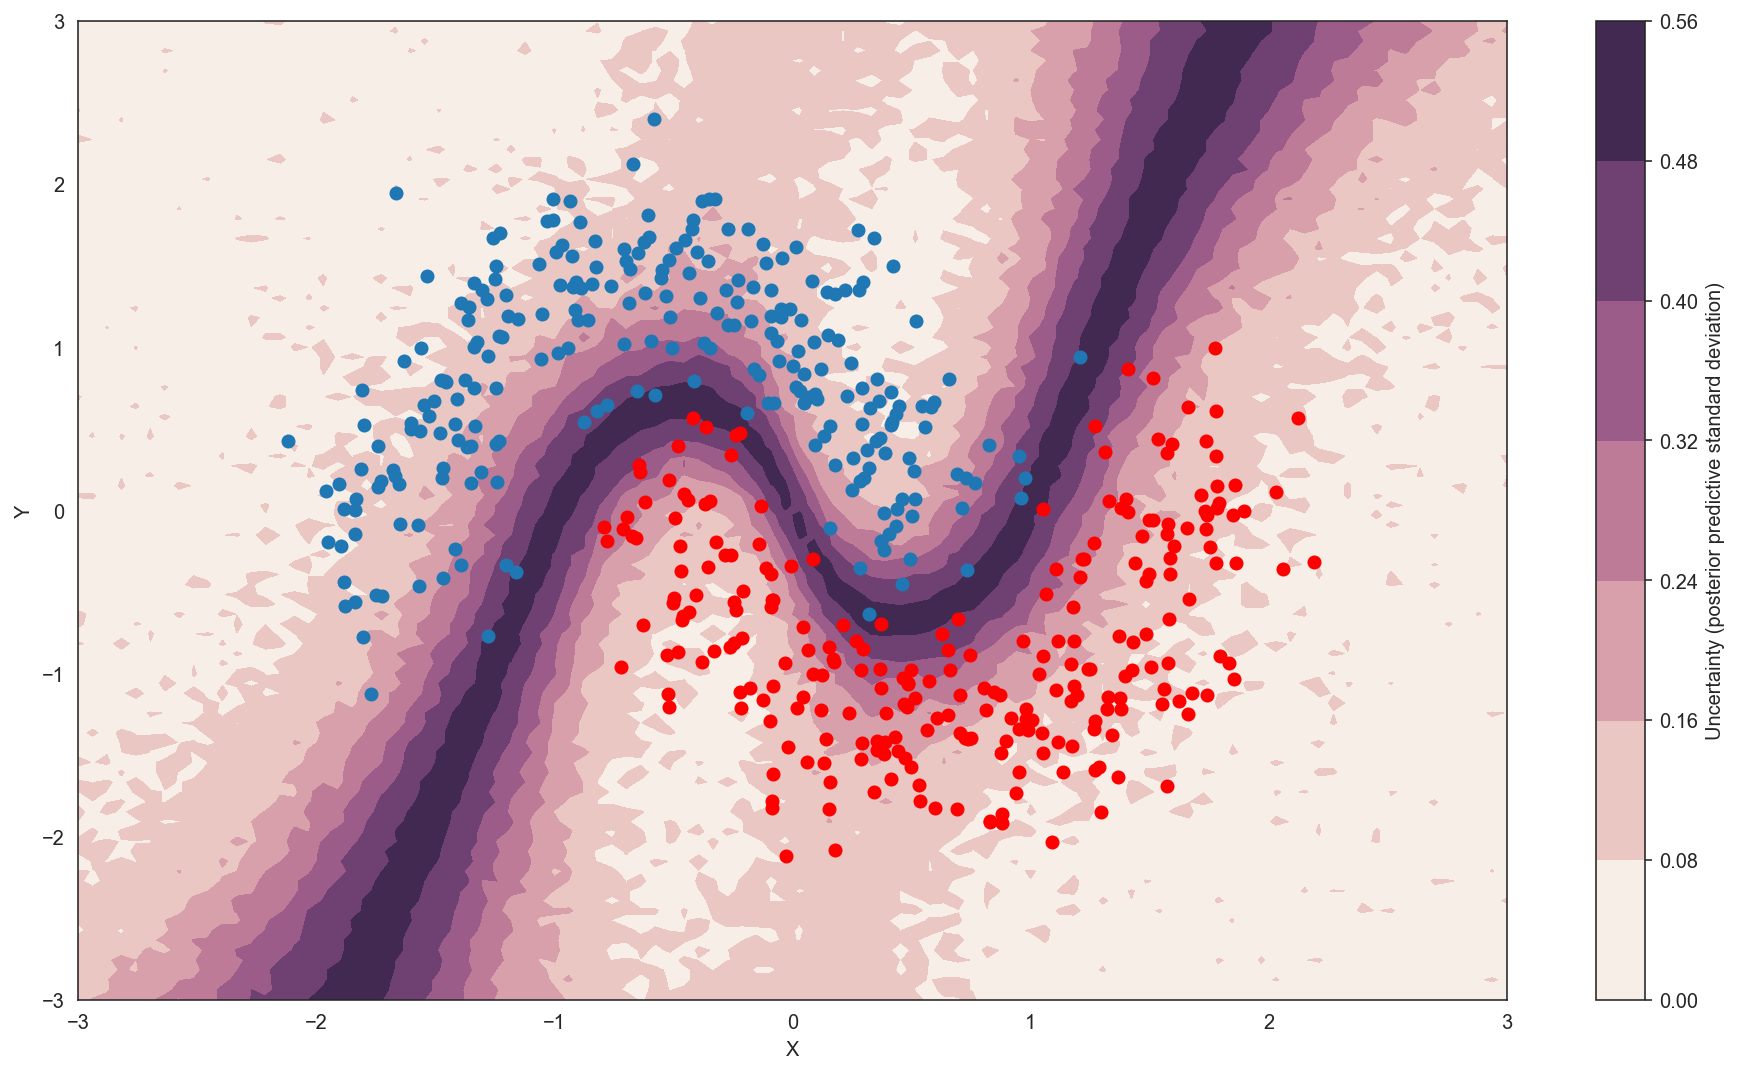

In [54]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], ppc["out"].std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');

# Frequentist Neural Network

In [61]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [102]:
NN_model = models.Sequential(name="NN_model")
NN_model.add(layers.Dense(5, activation="tanh", input_shape=(X_train.shape[1],)))
NN_model.add(layers.Dense(5, activation="tanh"))
NN_model.add(layers.Dense(1, activation="sigmoid"))
NN_model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(), metrics=["accuracy"])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
NN_history = NN_model.fit(X_train, Y_train, validation_split=0.2, epochs=800, callbacks=[early_stopping])

Epoch 1/800
13/13 [==============================] - 0s 7ms/step - loss: 0.9324 - accuracy: 0.3300 - val_loss: 0.8784 - val_accuracy: 0.3300
Epoch 2/800
13/13 [==============================] - 0s 2ms/step - loss: 0.8745 - accuracy: 0.3375 - val_loss: 0.8283 - val_accuracy: 0.3400
Epoch 3/800
13/13 [==============================] - 0s 2ms/step - loss: 0.8226 - accuracy: 0.3525 - val_loss: 0.7824 - val_accuracy: 0.3600
Epoch 4/800
13/13 [==============================] - 0s 2ms/step - loss: 0.7743 - accuracy: 0.3850 - val_loss: 0.7411 - val_accuracy: 0.4000
Epoch 5/800
13/13 [==============================] - 0s 2ms/step - loss: 0.7313 - accuracy: 0.4275 - val_loss: 0.7031 - val_accuracy: 0.4200
Epoch 6/800
13/13 [==============================] - 0s 2ms/step - loss: 0.6916 - accuracy: 0.4475 - val_loss: 0.6686 - val_accuracy: 0.4700
Epoch 7/800
13/13 [==============================] - 0s 2ms/step - loss: 0.6552 - accuracy: 0.4950 - val_loss: 0.6370 - val_accuracy: 0.5600
Epoch 8/800
1

Epoch 59/800
13/13 [==============================] - 0s 2ms/step - loss: 0.2736 - accuracy: 0.8725 - val_loss: 0.3609 - val_accuracy: 0.8400
Epoch 60/800
13/13 [==============================] - 0s 2ms/step - loss: 0.2732 - accuracy: 0.8750 - val_loss: 0.3605 - val_accuracy: 0.8400
Epoch 61/800
13/13 [==============================] - 0s 2ms/step - loss: 0.2728 - accuracy: 0.8750 - val_loss: 0.3604 - val_accuracy: 0.8400
Epoch 62/800
13/13 [==============================] - 0s 2ms/step - loss: 0.2725 - accuracy: 0.8750 - val_loss: 0.3603 - val_accuracy: 0.8500
Epoch 63/800
13/13 [==============================] - 0s 2ms/step - loss: 0.2720 - accuracy: 0.8775 - val_loss: 0.3602 - val_accuracy: 0.8500
Epoch 64/800
13/13 [==============================] - 0s 2ms/step - loss: 0.2718 - accuracy: 0.8800 - val_loss: 0.3597 - val_accuracy: 0.8500
Epoch 65/800
13/13 [==============================] - 0s 2ms/step - loss: 0.2712 - accuracy: 0.8800 - val_loss: 0.3596 - val_accuracy: 0.8400
Epoch 

13/13 [==============================] - 0s 2ms/step - loss: 0.2461 - accuracy: 0.8875 - val_loss: 0.3406 - val_accuracy: 0.8700
Epoch 117/800
13/13 [==============================] - 0s 2ms/step - loss: 0.2458 - accuracy: 0.8900 - val_loss: 0.3391 - val_accuracy: 0.8700
Epoch 118/800
13/13 [==============================] - 0s 2ms/step - loss: 0.2450 - accuracy: 0.8900 - val_loss: 0.3379 - val_accuracy: 0.8800
Epoch 119/800
13/13 [==============================] - 0s 2ms/step - loss: 0.2441 - accuracy: 0.8900 - val_loss: 0.3376 - val_accuracy: 0.8700
Epoch 120/800
13/13 [==============================] - 0s 2ms/step - loss: 0.2433 - accuracy: 0.8900 - val_loss: 0.3371 - val_accuracy: 0.8700
Epoch 121/800
13/13 [==============================] - 0s 2ms/step - loss: 0.2427 - accuracy: 0.8925 - val_loss: 0.3363 - val_accuracy: 0.8700
Epoch 122/800
13/13 [==============================] - 0s 2ms/step - loss: 0.2419 - accuracy: 0.8950 - val_loss: 0.3359 - val_accuracy: 0.8700
Epoch 123/800

13/13 [==============================] - 0s 2ms/step - loss: 0.1926 - accuracy: 0.9425 - val_loss: 0.2847 - val_accuracy: 0.9100
Epoch 174/800
13/13 [==============================] - 0s 2ms/step - loss: 0.1917 - accuracy: 0.9425 - val_loss: 0.2840 - val_accuracy: 0.9100
Epoch 175/800
13/13 [==============================] - 0s 2ms/step - loss: 0.1904 - accuracy: 0.9425 - val_loss: 0.2821 - val_accuracy: 0.9100
Epoch 176/800
13/13 [==============================] - 0s 2ms/step - loss: 0.1893 - accuracy: 0.9425 - val_loss: 0.2805 - val_accuracy: 0.9100
Epoch 177/800
13/13 [==============================] - 0s 2ms/step - loss: 0.1882 - accuracy: 0.9425 - val_loss: 0.2801 - val_accuracy: 0.9100
Epoch 178/800
13/13 [==============================] - 0s 2ms/step - loss: 0.1873 - accuracy: 0.9425 - val_loss: 0.2802 - val_accuracy: 0.9100
Epoch 179/800
13/13 [==============================] - 0s 2ms/step - loss: 0.1860 - accuracy: 0.9425 - val_loss: 0.2780 - val_accuracy: 0.9100
Epoch 180/800

13/13 [==============================] - 0s 2ms/step - loss: 0.1384 - accuracy: 0.9575 - val_loss: 0.2186 - val_accuracy: 0.9300
Epoch 231/800
13/13 [==============================] - 0s 2ms/step - loss: 0.1369 - accuracy: 0.9575 - val_loss: 0.2184 - val_accuracy: 0.9300
Epoch 232/800
13/13 [==============================] - 0s 2ms/step - loss: 0.1365 - accuracy: 0.9600 - val_loss: 0.2162 - val_accuracy: 0.9300
Epoch 233/800
13/13 [==============================] - 0s 2ms/step - loss: 0.1355 - accuracy: 0.9625 - val_loss: 0.2153 - val_accuracy: 0.9300
Epoch 234/800
13/13 [==============================] - 0s 2ms/step - loss: 0.1347 - accuracy: 0.9600 - val_loss: 0.2150 - val_accuracy: 0.9300
Epoch 235/800
13/13 [==============================] - 0s 2ms/step - loss: 0.1339 - accuracy: 0.9600 - val_loss: 0.2138 - val_accuracy: 0.9300
Epoch 236/800
13/13 [==============================] - 0s 2ms/step - loss: 0.1333 - accuracy: 0.9625 - val_loss: 0.2128 - val_accuracy: 0.9300
Epoch 237/800

13/13 [==============================] - 0s 2ms/step - loss: 0.1035 - accuracy: 0.9750 - val_loss: 0.1738 - val_accuracy: 0.9500
Epoch 288/800
13/13 [==============================] - 0s 2ms/step - loss: 0.1033 - accuracy: 0.9725 - val_loss: 0.1711 - val_accuracy: 0.9600
Epoch 289/800
13/13 [==============================] - 0s 2ms/step - loss: 0.1028 - accuracy: 0.9725 - val_loss: 0.1711 - val_accuracy: 0.9600
Epoch 290/800
13/13 [==============================] - 0s 2ms/step - loss: 0.1022 - accuracy: 0.9750 - val_loss: 0.1717 - val_accuracy: 0.9600
Epoch 291/800
13/13 [==============================] - 0s 2ms/step - loss: 0.1019 - accuracy: 0.9750 - val_loss: 0.1733 - val_accuracy: 0.9500
Epoch 292/800
13/13 [==============================] - 0s 2ms/step - loss: 0.1016 - accuracy: 0.9750 - val_loss: 0.1724 - val_accuracy: 0.9500
Epoch 293/800
13/13 [==============================] - 0s 2ms/step - loss: 0.1012 - accuracy: 0.9750 - val_loss: 0.1717 - val_accuracy: 0.9500
Epoch 294/800

13/13 [==============================] - 0s 2ms/step - loss: 0.0872 - accuracy: 0.9750 - val_loss: 0.1484 - val_accuracy: 0.9600
Epoch 345/800
13/13 [==============================] - 0s 2ms/step - loss: 0.0868 - accuracy: 0.9750 - val_loss: 0.1495 - val_accuracy: 0.9600
Epoch 346/800
13/13 [==============================] - 0s 2ms/step - loss: 0.0864 - accuracy: 0.9775 - val_loss: 0.1500 - val_accuracy: 0.9600
Epoch 347/800
13/13 [==============================] - 0s 2ms/step - loss: 0.0863 - accuracy: 0.9775 - val_loss: 0.1496 - val_accuracy: 0.9600
Epoch 348/800
13/13 [==============================] - 0s 2ms/step - loss: 0.0862 - accuracy: 0.9775 - val_loss: 0.1509 - val_accuracy: 0.9600
Epoch 349/800
13/13 [==============================] - 0s 2ms/step - loss: 0.0863 - accuracy: 0.9775 - val_loss: 0.1533 - val_accuracy: 0.9600
Epoch 350/800
13/13 [==============================] - 0s 2ms/step - loss: 0.0861 - accuracy: 0.9750 - val_loss: 0.1519 - val_accuracy: 0.9600
Epoch 351/800

13/13 [==============================] - 0s 2ms/step - loss: 0.0804 - accuracy: 0.9725 - val_loss: 0.1353 - val_accuracy: 0.9600
Epoch 402/800
13/13 [==============================] - 0s 2ms/step - loss: 0.0799 - accuracy: 0.9750 - val_loss: 0.1381 - val_accuracy: 0.9600
Epoch 403/800
13/13 [==============================] - 0s 2ms/step - loss: 0.0801 - accuracy: 0.9750 - val_loss: 0.1392 - val_accuracy: 0.9600
Epoch 404/800
13/13 [==============================] - 0s 2ms/step - loss: 0.0799 - accuracy: 0.9750 - val_loss: 0.1361 - val_accuracy: 0.9600
Epoch 405/800
13/13 [==============================] - 0s 2ms/step - loss: 0.0795 - accuracy: 0.9750 - val_loss: 0.1392 - val_accuracy: 0.9600
Epoch 406/800
13/13 [==============================] - 0s 2ms/step - loss: 0.0793 - accuracy: 0.9775 - val_loss: 0.1386 - val_accuracy: 0.9600
Epoch 407/800
13/13 [==============================] - 0s 2ms/step - loss: 0.0794 - accuracy: 0.9775 - val_loss: 0.1383 - val_accuracy: 0.9600
Epoch 408/800

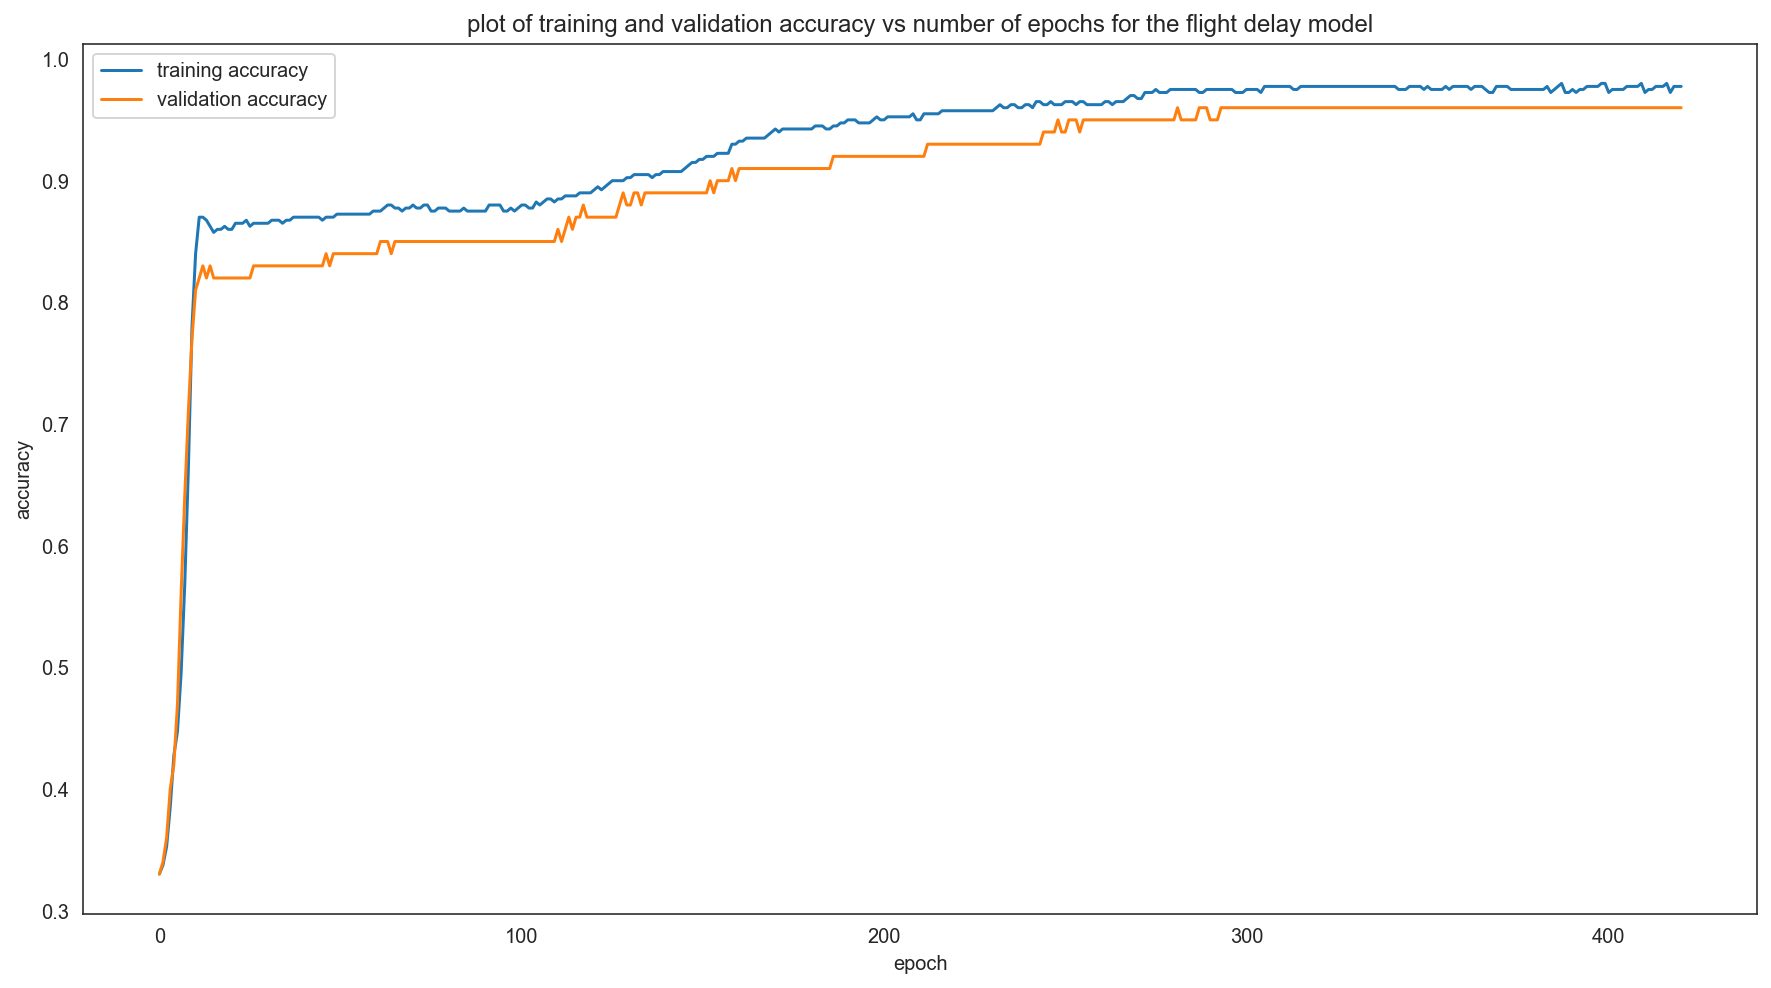

In [103]:
plt.figure(figsize=(15,8))
plt.plot(NN_history.history["accuracy"], label="training accuracy")
plt.plot(NN_history.history["val_accuracy"], label="validation accuracy")
plt.legend()
plt.title("plot of training and validation accuracy vs number of epochs for the flight delay model")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

In [104]:
train_acc = NN_model.evaluate(X_train, Y_train, verbose=0)[1]
test_acc = NN_model.evaluate(X_test, Y_test, verbose=0)[1]
print("The training accuracy is {:.4f} and the testing accuracy is {:.4f}".format(train_acc, test_acc))

The training accuracy is 0.9720 and the testing accuracy is 0.9580


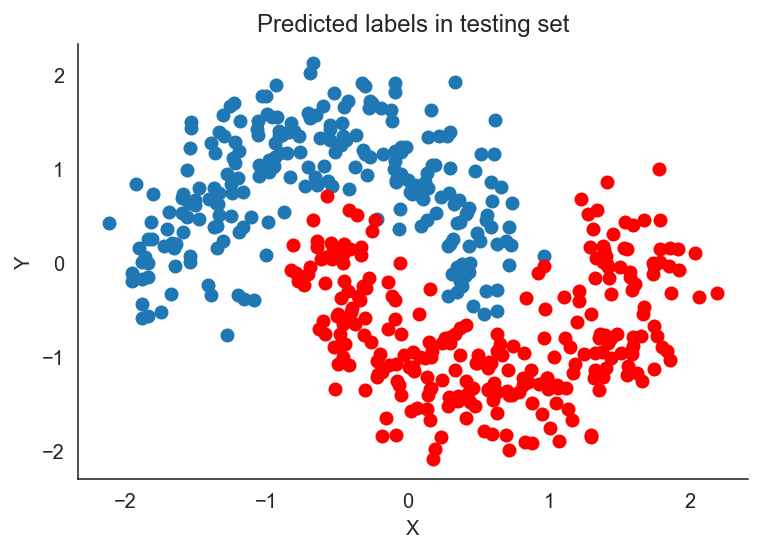

In [105]:
pred = NN_model.predict(X_test).flatten() > 0.5
fig, ax = plt.subplots()
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
sns.despine()
ax.set(title='Predicted labels in testing set', xlabel='X', ylabel='Y');

In [106]:
pred2 = NN_model.predict(grid_2d).flatten()

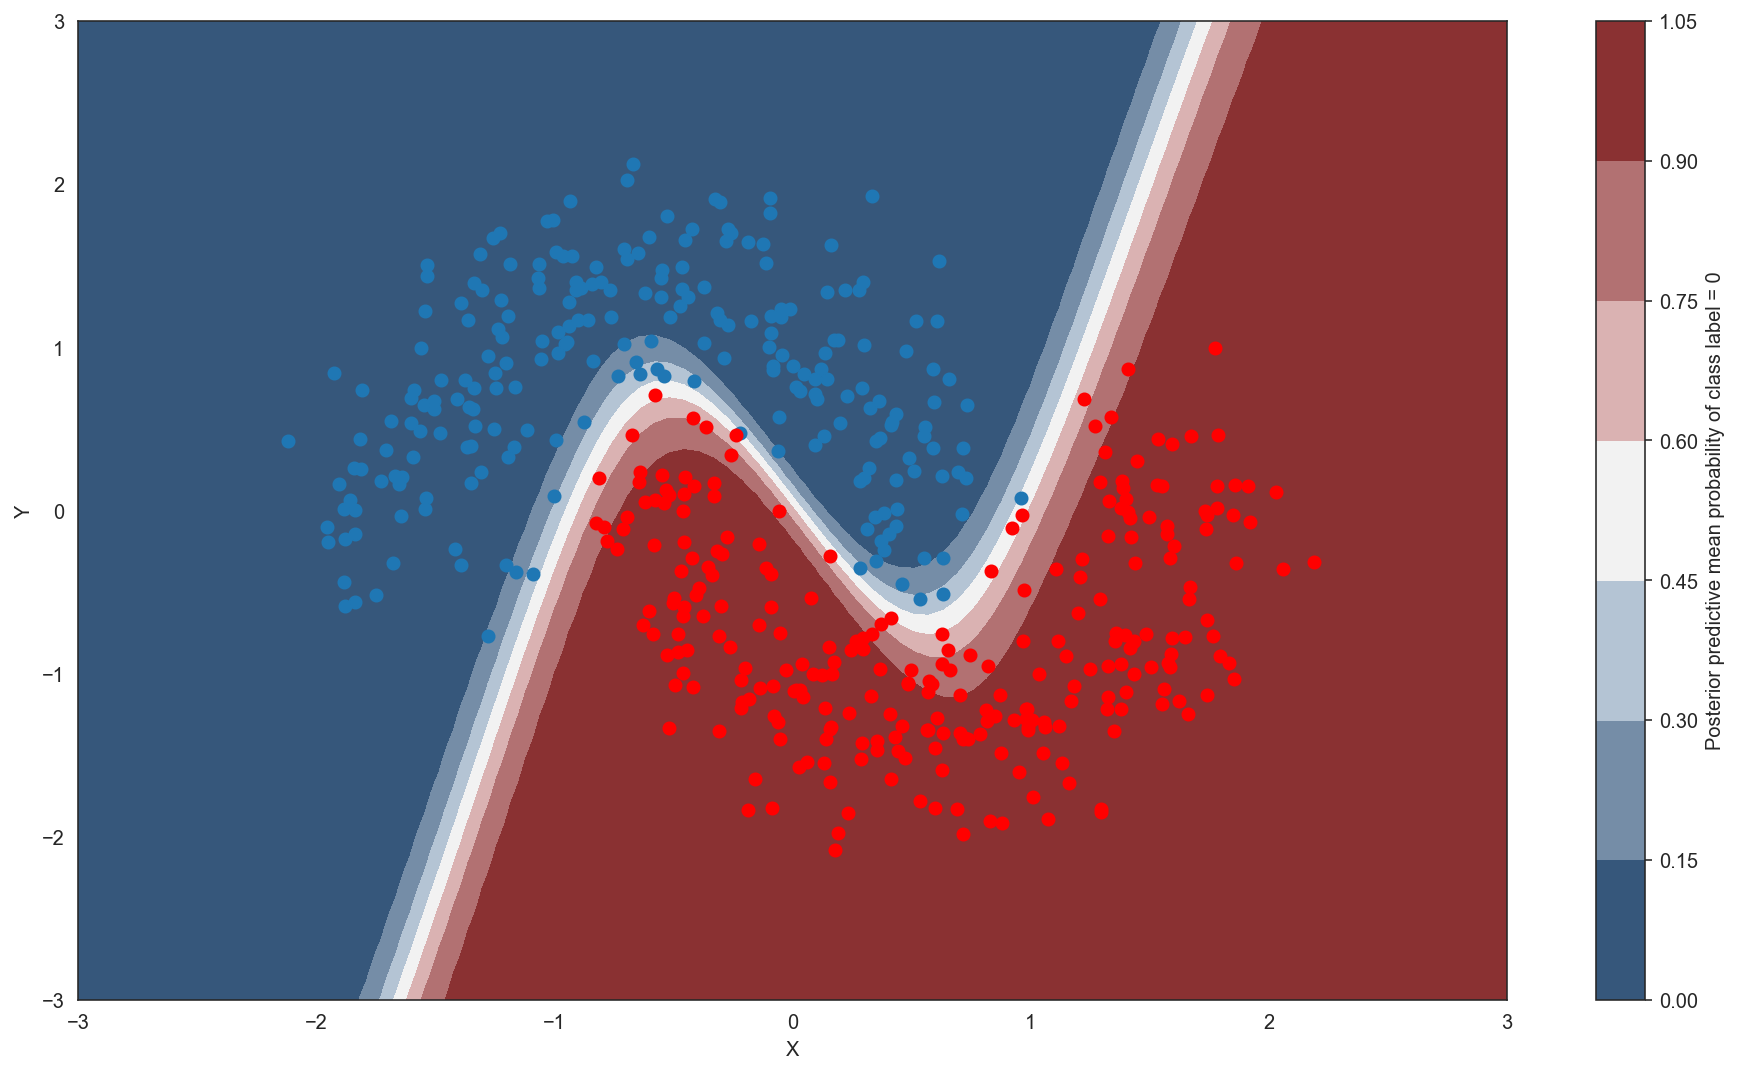

In [107]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], pred2.reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');